# Library Book Request Optimization

## Generating Data

## Branches

In [1]:
import pandas as pd 

df_branches = pd.read_csv("branches.csv")
df_branches.head(3)

,branch_id,branch_name,branch_address,latitude,longitude
0,1,Arverne,"312 Beach 54th Street, Arverne, NY 11692",40.5897,-73.7722
1,2,Astoria,"14-01 Astoria Boulevard, Astoria, NY 11102",40.7724,-73.9244
2,3,Auburndale,"25-55 Francis Lewis Boulevard, Flushing, NY 11358",40.7647,-73.8000


In [2]:
import folium

# Create a map centered around the first location
m = folium.Map(location=[df_branches['latitude'].iloc[0], df_branches['longitude'].iloc[0]], zoom_start=10)

# Add markers for each location in the dataframe
for _, row in df_branches.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(m)

m

## Books

In [3]:
import random
from faker import Faker

In [4]:
# Initialize Faker instance for generating random titles
fake = Faker()

# Set parameters
num_books = 10_000
num_libraries = 64

# Generate unique ISBNs for each book
def generate_isbn():
    return ''.join([str(random.randint(0, 9)) for _ in range(13)])

# Ensure unique ISBNs
isbns = set()
while len(isbns) < num_books:
    isbns.add(generate_isbn())

# Convert to list for later use
isbns = list(isbns)

In [5]:
# List of genres
genres = ['Fiction', 'Non-fiction', 'Fantasy', 'Mystery', 'Science Fiction', 'Biography', 'Thriller', 'Romance', 'Historical', 'Children']

# Generate data for books
books = []
current_book_id = 1  # Start unique book_id from 1

for isbn in isbns:
    title = fake.catch_phrase()  # Generate random book title
    genre = random.choice(genres)  # Randomly choose a genre
    branch_ids = random.sample(range(1, num_libraries + 1), random.randint(1, num_libraries // 2))  # Randomly select libraries for this book
    
    for branch_id in branch_ids:
        # Append book entry with a unique book_id
        books.append([current_book_id, isbn, title, genre, branch_id])
        current_book_id += 1  # Increment book_id for each library instance

# Create DataFrame for books
df_books = pd.DataFrame(books, columns=['book_id', 'isbn', 'title', 'genre', 'branch_id'])

In [8]:
df_books.head(3)

,book_id,isbn,title,genre,branch_id
0,1,4454440280402,Networked tertiary throughput,Mystery,58
1,2,4454440280402,Networked tertiary throughput,Mystery,28
2,3,4454440280402,Networked tertiary throughput,Mystery,51


In [9]:
df_books.sample(3)

,book_id,isbn,title,genre,branch_id
105975,105976,8334821234003,Realigned system-worthy function,Biography,63
72605,72606,6404522560632,Virtual content-based methodology,Children,34
104030,104031,9033675642254,Progressive bottom-line project,Fiction,26


In [10]:
df_books.shape

(164591, 5)

## Members

In [41]:
# Set parameters
num_users = 10_000
num_libraries = 64

In [42]:
library_distribution = [random.gauss(0, 1) for _ in range(num_libraries)]  # Using Gaussian for randomness
library_distribution = [abs(int(x * 100)) for x in library_distribution] 
total_users = sum(library_distribution)
library_distribution = [int((x / total_users) * num_users) for x in library_distribution]

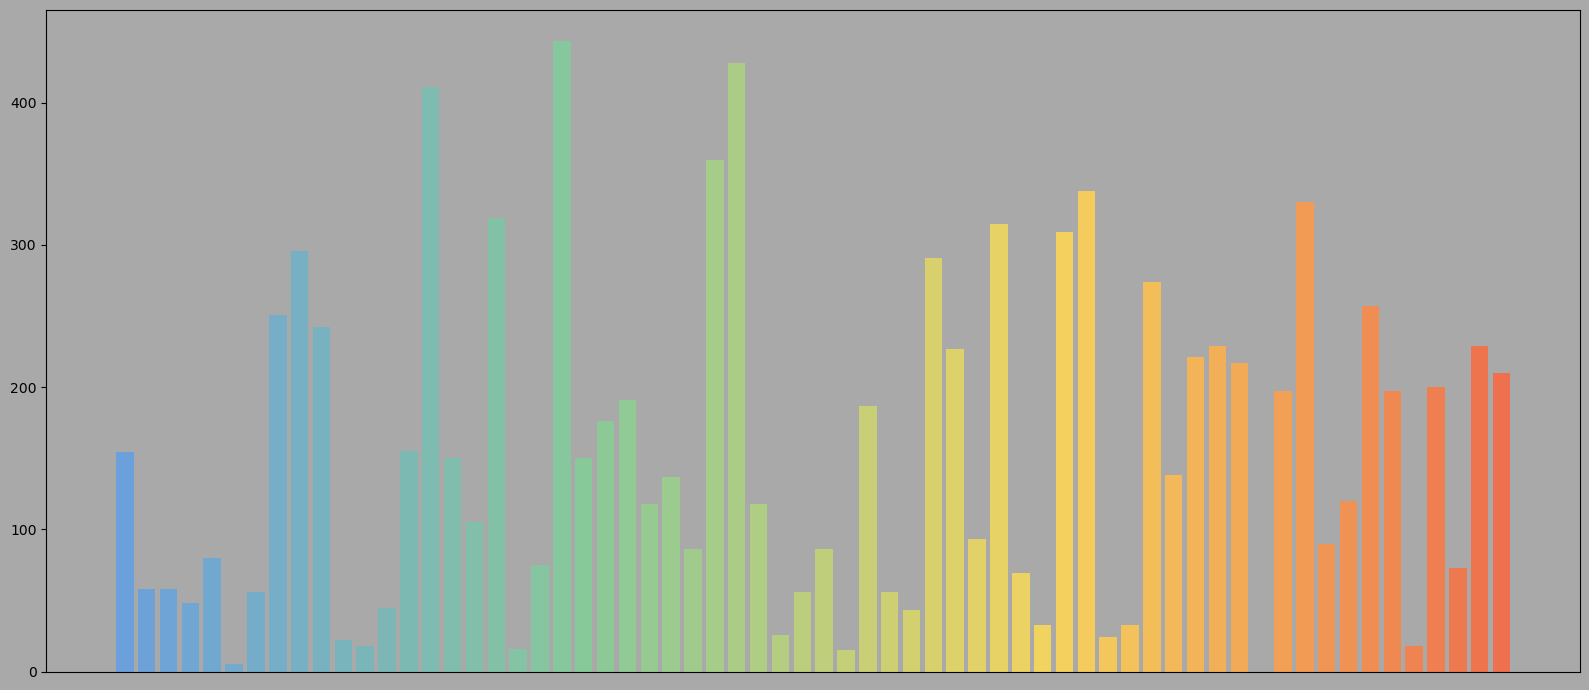

In [43]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_gradient',
    ['#6CA0DC', '#88C999', '#F4D35E', '#EE6C4D']
)

# Normalize x values to 0-1 for the colormap
norm = mcolors.Normalize(vmin=0, vmax=64)
colors = cmap(norm(range(64)))

# Plot
fig, ax = plt.subplots(figsize=(16, 7))
fig.patch.set_facecolor('darkgrey')  # light grey background
ax.set_facecolor('darkgray')

ax.bar(range(64), library_distribution, color=colors)
ax.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tight_layout()
plt.show()

In [44]:
# Generate random users with only user_id and home_branch
users = []
user_id = 1

for branch_id, num_members in enumerate(library_distribution, 1):
    for _ in range(num_members):
        users.append([user_id, branch_id])
        user_id += 1

# Create DataFrame for users
df_users = pd.DataFrame(users, columns=['user_id', 'home_branch'])

# Display the first few rows
df_users.head()

,user_id,home_branch
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [45]:
df_users.shape

(9972, 2)

In [46]:
df_users.groupby(df_users.home_branch).sum().sort_values('user_id')

,user_id
home_branch,
6,2005
2,10643
1,11935
3,14007
4,14136
...,...
64,2072175
63,2209392
45,2280317


## Requests

In [56]:
import numpy as np
from datetime import timedelta

today = pd.Timestamp.today()
num_users = len(df_users)

# Shuffle and split users
shuffled_users = df_users.sample(frac=1, random_state=42).reset_index(drop=True)
inactive_users = shuffled_users.iloc[:int(0.15 * num_users)]
regular_users = shuffled_users.iloc[int(0.15 * num_users):int(0.85 * num_users)]
power_users   = shuffled_users.iloc[int(0.85 * num_users):]

# Assign request counts
def sample_requests(n, mean, std, low, high):
    return np.clip(np.round(np.random.normal(mean, std, n)), low, high).astype(int)

regular_counts = sample_requests(len(regular_users), mean=5, std=2, low=1, high=10)
power_counts   = sample_requests(len(power_users), mean=20, std=5, low=10, high=30)

# Generate timestamps
def random_timestamp():
    return today - pd.to_timedelta(np.random.randint(0, 365*24*60*60), unit='s')

# Build requests
def build_requests(users, counts):
    user_ids = np.repeat(users['user_id'].values, counts)
    home_branches = np.repeat(users['home_branch'].values, counts)
    sampled_books = df_books.sample(len(user_ids), replace=True).reset_index(drop=True)
    
    return pd.DataFrame({
        'request_id': np.arange(1, len(user_ids) + 1),
        'book_id': sampled_books['book_id'].values,
        'user_id': user_ids,
        'from_branch': sampled_books['branch_id'].values,
        'to_branch': home_branches,
        'timestamp': [random_timestamp() for _ in range(len(user_ids))]
    })

# Combine all requests
df_requests = pd.concat([
    build_requests(regular_users.reset_index(drop=True), regular_counts),
    build_requests(power_users.reset_index(drop=True), power_counts)
], ignore_index=True)

df_requests.head()

,request_id,book_id,user_id,from_branch,to_branch,timestamp
0,1,34985,7117,8,48,2025-03-10 09:31:27.331467
1,2,106955,7117,50,48,2024-05-06 12:32:55.331467
2,3,103949,7117,44,48,2025-03-27 12:14:19.331467
3,4,118163,9915,8,64,2024-11-13 10:21:50.331467
4,5,105103,9915,18,64,2024-10-01 06:04:19.331467


## Transport

In [49]:
branch_coords = df_branches.set_index('branch_id')[['latitude', 'longitude']]

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

# Compute distances for request transports
def compute_distance(row):
    coord_from = branch_coords.loc[row['from_branch']]
    coord_to   = branch_coords.loc[row['to_branch']]
    return haversine(coord_from.latitude, coord_from.longitude, coord_to.latitude, coord_to.longitude)

In [57]:
df_requests['distance'] = df_requests.apply(compute_distance, axis=1)
df_requests['transport_type'] = 'request'

In [58]:
# Create return transports
df_return = df_requests.copy()
df_return['from_branch'], df_return['to_branch'] = df_requests['to_branch'], df_requests['from_branch']
df_return['distance'] = df_return.apply(compute_distance, axis=1)
df_return['transport_type'] = 'return'

In [60]:
# Combine and assign transport_id
df_transports = pd.concat([df_requests, df_return], ignore_index=True)
df_transports.insert(0, 'transport_id', np.arange(1, len(df_transports) + 1))

# Final columns
df_transports = df_transports[['transport_id', 'book_id', 'from_branch', 'to_branch', 'distance', 'transport_type']]

In [62]:
df_transports.sample(5)

,transport_id,book_id,from_branch,to_branch,distance,transport_type
42952,42953,163030,22,63,8.383523,request
19624,19625,108308,43,45,22.747927,request
17657,17658,104027,57,15,11.064677,request
109069,109070,105659,45,4,13.182033,return
61571,61572,20712,10,50,10.333699,request


## Optimization

## 1. Consolidate Shipment

In [77]:
# Create a 'date' column (only date, without time)
df_requests['date'] = df_requests['timestamp'].dt.date

# Group by (from_branch, to_branch, date)
batched_transports = df_requests.groupby(['from_branch', 'to_branch', 'date']).agg({
    'book_id': list,    # List of book_ids being transported
}).reset_index()

print('New number of transports')
print(str(round((len(batched_transports) / len(df_requests) * 100), 4)) + ' %')

New number of transports
96.7389 %


In [80]:
# Create a '5-day batch' column
df_requests['5_day_batch'] = (df_requests['timestamp'].dt.floor('5D'))

# Group by (from_branch, to_branch, 5-day batch)
batched_transports = df_requests.groupby(['from_branch', 'to_branch', '5_day_batch']).agg({
    'book_id': list,    # List of book_ids transported
    'distance': 'mean', # Mean distance between from and to branch
    'request_id': list, # List of request_ids
}).reset_index()

# Calculate original and batched total distances
# (Before batching: each transport had its own distance)
original_total_distance = df_requests['distance'].sum()

# (After batching: each batch counts distance ONCE)
batched_total_distance = batched_transports['distance'].sum()

# Calculate savings
distance_reduction_percent = 100 * (1 - (batched_total_distance / original_total_distance))

# Print results
print(f"Original total distance: {original_total_distance:.2f}")
print(f"Batched total distance (5-day windows): {batched_total_distance:.2f}")
print(f"Distance reduction: {distance_reduction_percent:.2f}%")

# See sample of batched transports
batched_transports.sample(5)

Original total distance: 590353.54
Batched total distance (5-day windows): 502540.28
Distance reduction: 14.87%


,from_branch,to_branch,5_day_batch,book_id,distance,request_id
53224,62,61,2024-04-27,[163079],8.946077,[6923]
16398,20,21,2024-07-21,"[102633, 156799, 156967]",4.730490,"[7061, 20564, 21765]"
7673,10,8,2024-09-04,[145401],10.187056,[34498]
47214,55,54,2025-04-07,[45199],15.239156,[10203]
36472,43,29,2024-06-26,"[60180, 77785]",19.446094,"[384, 18785]"


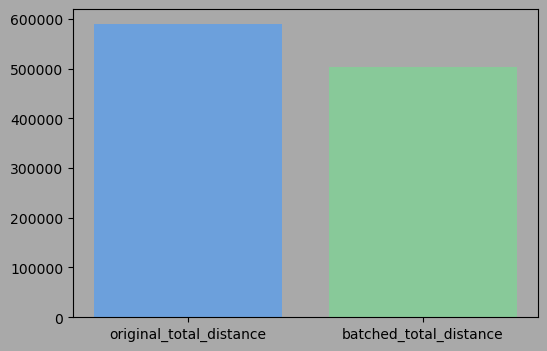

In [91]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor('darkgrey')  # light grey background
ax.set_facecolor('darkgray')

ax.bar(['original_total_distance', 'batched_total_distance'],
        [original_total_distance, batched_total_distance], 
        color=['#6CA0DC', '#88C999']);

## Select Closest Available Copy

#### Distance Matrix for distance lookup

In [96]:
branch_pairs = pd.merge(
    df_branches[['branch_id', 'latitude', 'longitude']],
    df_branches[['branch_id', 'latitude', 'longitude']],
    how='cross',
    suffixes=('_from', '_to')
)

# Calculate Haversine distance for each pair
branch_pairs['distance'] = haversine(
    branch_pairs['latitude_from'], branch_pairs['longitude_from'],
    branch_pairs['latitude_to'], branch_pairs['longitude_to']
)

# Create a lookup dictionary: (from_branch, to_branch) -> distance
distance_lookup = {
    (row['branch_id_from'], row['branch_id_to']): row['distance']
    for _, row in branch_pairs.iterrows()
}

#### selecting closest availaible copy

In [101]:
# Group by ISBN, get all branch_ids where the book exists
book_availability = df_books.groupby('isbn')['branch_id'].apply(list).to_dict()

# First, map book_id -> isbn (because df_requests has book_id)
bookid_to_isbn = df_books.set_index('book_id')['isbn'].to_dict()

# Add isbn column to df_requests
df_requests['isbn'] = df_requests['book_id'].map(bookid_to_isbn)

# Prepare list to store optimized from_branch
optimized_from_branches = []
optimized_distances = []

# Iterate over requests
for idx, row in df_requests.iterrows():
    isbn = row['isbn']
    user_home_branch = row['to_branch']
    
    available_branches = book_availability.get(isbn, [])
    
    if not available_branches:
        # No available branches found (should not happen if data clean)
        optimized_from_branches.append(row['from_branch'])  # fallback to original
        optimized_distances.append(row['distance'])         # fallback
        continue
    
    # Find closest available branch
    min_distance = float('inf')
    best_branch = None
    for branch in available_branches:
        dist = distance_lookup.get((branch, user_home_branch), float('inf'))
        if dist < min_distance:
            min_distance = dist
            best_branch = branch

    optimized_from_branches.append(best_branch)
    optimized_distances.append(min_distance)

# Add new columns
df_requests['optimized_from_branch'] = optimized_from_branches
df_requests['optimized_distance'] = optimized_distances

In [102]:
# Original total distance
original_total_distance = df_requests['distance'].sum()

# Optimized total distance
optimized_total_distance = df_requests['optimized_distance'].sum()

# Distance reduction %
distance_reduction_percent = 100 * (1 - (optimized_total_distance / original_total_distance))

print(f"Original total distance: {original_total_distance:.2f} km")
print(f"Optimized total distance: {optimized_total_distance:.2f} km")
print(f"Distance saved: {distance_reduction_percent:.2f}%")

Original total distance: 590353.54 km
Optimized total distance: 102809.76 km
Distance saved: 82.59%


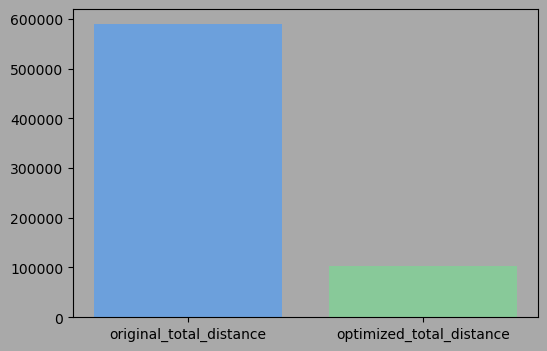

In [103]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor('darkgrey')  # light grey background
ax.set_facecolor('darkgray')

ax.bar(['original_total_distance', 'optimized_total_distance'],
        [original_total_distance, optimized_total_distance], 
        color=['#6CA0DC', '#88C999']);

### Optimizing Transport Routes (TSP)
(for a 5-day batch)

In [106]:
df_requests['timestamp'] = pd.to_datetime(df_requests['timestamp'])
df_requests['date_batch'] = df_requests['timestamp'].dt.floor('5D')

# Group by each 5-day batch
batch_sizes = df_requests.groupby('date_batch').size().reset_index(name='num_transports')

# Sort by batch size
batch_sizes = batch_sizes.sort_values('num_transports', ascending=False)
batch_sizes

,date_batch,num_transports
64,2025-03-08,948
59,2025-02-11,941
27,2024-09-04,939
60,2025-02-16,938
17,2024-07-16,929
...,...,...
1,2024-04-27,837
57,2025-02-01,836
9,2024-06-06,834
51,2025-01-02,832


In [109]:
# We will first do TSP on batch '2024-04-22'
batch_date = pd.to_datetime('2024-04-22')  # your batch
batch_requests = df_requests[df_requests['date_batch'] == batch_date].copy()

print(f"Number of transports in batch {batch_date.date()}: {len(batch_requests)}")

Number of transports in batch 2024-04-22: 68


In [110]:
# Get all from and to branches
pickup_branches = batch_requests['optimized_from_branch'].tolist()
delivery_branches = batch_requests['to_branch'].tolist()

# Unique list of all branches involved
branches_involved = list(set(pickup_branches + delivery_branches))

print(f"Number of unique branches involved: {len(branches_involved)}")
print(branches_involved)

Number of unique branches involved: 53
[1, 2, 4, 5, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64]


In [111]:
# Mapping real branch IDs to matrix indices
branch_to_idx = {branch_id: idx for idx, branch_id in enumerate(branches_involved)}
idx_to_branch = {idx: branch_id for branch_id, idx in branch_to_idx.items()}

# 2. Building the distance matrix for ortools
num_branches = len(branches_involved)
distance_matrix = np.zeros((num_branches, num_branches))

for i, branch_i in enumerate(branches_involved):
    for j, branch_j in enumerate(branches_involved):
        if i == j:
            distance_matrix[i][j] = 0
        else:
            distance_matrix[i][j] = distance_lookup.get((branch_i, branch_j), 1e6)  # Big number if missing


In [113]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Create Routing Index Manager
manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)  # 1 vehicle, starting at node 0

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

# Distance callback
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(distance_matrix[from_node][to_node] * 1000)  # OR-Tools needs integer costs

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Set search parameters
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve
solution = routing.SolveWithParameters(search_parameters)

# Extract and print the route
if solution:
    index = routing.Start(0)
    route = []
    route_distance = 0
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(idx_to_branch[node_index])
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)

    route.append(idx_to_branch[manager.IndexToNode(index)])  # Return to start (if needed)
    print("Optimized Route of Branch IDs:")
    print(route)
else:
    print("No solution found!")

Optimized Route of Branch IDs:
[1, 43, 54, 9, 27, 57, 4, 52, 56, 12, 8, 50, 63, 51, 14, 28, 48, 59, 2, 10, 64, 36, 38, 24, 40, 21, 49, 13, 31, 34, 18, 29, 16, 45, 61, 47, 20, 37, 39, 17, 44, 30, 25, 22, 5, 15, 41, 23, 62, 26, 55, 58, 53, 1]


In [114]:
# Sum the optimized distances for this batch
total_batch_distance_before = batch_requests['optimized_distance'].sum()

# Convert route_distance to kilometers if needed
total_batch_distance_after = route_distance / 1000

distance_saved_percent = 100 * (1 - (total_batch_distance_after / total_batch_distance_before))
print(f"Total batch distance before optimization: {total_batch_distance_before:.2f} km")
print(f"Total batch distance after optimization (TSP route): {total_batch_distance_after:.2f} km")
print(f"Distance saved: {distance_saved_percent:.2f}%")

Total batch distance before optimization: 125.90 km
Total batch distance after optimization (TSP route): 107.27 km
Distance saved: 14.80%


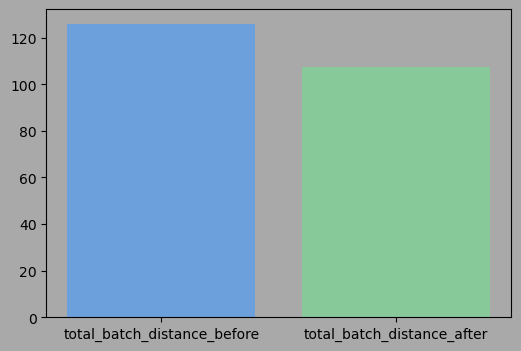

In [115]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.patch.set_facecolor('darkgrey')  # light grey background
ax.set_facecolor('darkgray')

ax.bar(['total_batch_distance_before', 'total_batch_distance_after'],
        [total_batch_distance_before, total_batch_distance_after], 
        color=['#6CA0DC', '#88C999']);